In [1]:
from scipy.io import loadmat

data = loadmat('raw_training_data.mat')

In [2]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Apr 10 12:52:24 2020',
 '__version__': '1.0',
 '__globals__': [],
 'train_dg': array([[array([[-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                [-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                [-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                ...,
                [ 2.0240593 , -0.35267067, -0.19278526, -0.19677258, -0.27182388],
                [ 2.00303459, -0.35165787, -0.19276047, -0.19695473, -0.27204323],
                [ 1.98193359, -0.3506403 , -0.19273472, -0.19713593, -0.27226353]])],
        [array([[-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                [-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                [-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                ...,
                [-0.59470844,  0.30090046, -0.35142422,  0

In [9]:
#filter function
def filter_ecog(raw_ecog, lowfreq=1, highfreq=100, fs=1000, order=301, notch_freq=60.0):
  '''
  Function to filter raw ecog

  Inputs:
  raw_ecog = numpy array of raw signal
  lowfreq = lower end of bandpass. Uses 1Hz
  highfreq = high end of band pass. 110Hz
  fs = sampling frequency. 1000Hz
  order = order of filter. 4
  notch_freq = frequency of notch filter. 60Hz
  Q = quality factor for notch filter. 30

  Outputs:
  filtered_ecog = numpy array of filtered signal
  '''

  from scipy.signal import firwin, filtfilt

  nyq = fs / 2
  low = lowfreq / nyq
  high = highfreq / nyq

  # Bandpass filter (1–100 Hz)
  bandpass_fir = firwin(order, [low, high], pass_zero=False)

  # Notch filter at 60 Hz (narrow bandstop)
  notch_fir = firwin(order, [(notch_freq - 1)/nyq, (notch_freq + 1)/nyq], pass_zero=True)

  # Apply bandpass filter first
  filtered_signal = filtfilt(bandpass_fir, [1.0], raw_ecog, axis=0)

  # Apply notch filter
  filtered_ecog = filtfilt(notch_fir, [1.0], filtered_signal, axis=0)

  return filtered_ecog

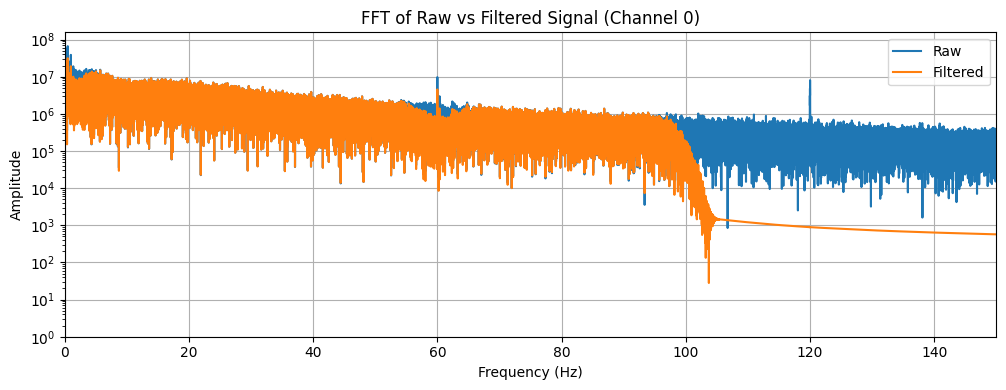

In [10]:
from scipy.fft import fft, fftfreq

raw_ecog = data['train_ecog'][0][0]
raw_ch = raw_ecog[:, 0]
filtered_ch = filter_ecog(raw_ch)

# FFT
raw_fft = fft(raw_ch)
filt_fft = fft(filtered_ch)

from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

fs = 1000  # Hz
N = len(raw_ch)  # total samples
timestep = 1 / fs

# Pick one channel
raw_ch = raw_ecog[:, 0]
filtered_ch = filter_ecog(raw_ch)

# FFT
raw_fft = fft(raw_ch)
filt_fft = fft(filtered_ch)
freqs = fftfreq(N, timestep)

# Plot positive frequencies only
plt.figure(figsize=(10, 4))
plt.plot(freqs[:N//2], np.abs(raw_fft[:N//2]), label='Raw')
plt.plot(freqs[:N//2], np.abs(filt_fft[:N//2]), label='Filtered')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Raw vs Filtered Signal (Channel 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,150)
#plt.ylim(0, 1e7/5)
plt.yscale('log')
plt.show()


Initial FFT analysis of butterworth alone showed there were 60Hz peak that was removed with notch filter. Band pass shown to worked especially near the 0-5Hz range where low frequency drift occurs. Also low amplitude shown after 100Hz. Though raw signal also has los amplitude there. But 120Hz peak in raw is not in filtered so assuming bandpass works.

In [11]:
#Get windows
def get_windows(filtered_ecog, fs = 1000, winLen = 0.1, winShift = 0.05):
  '''
  Function to get the windows in the filtered signal

  Inputs
  filtered_ecog = numpy array of filtered ecog
  fs = sampling frequency. 1000Hz
  winLen = window length in seconds. 0.1
  winShift = window shift in seconds. 0.05

  Outputs
  window_data = list of numpy arrays of windows
  '''
  import numpy as np

  #initialize windows
  window_data = []

  #get number of windows
  xLen = len(filtered_ecog) #get length of signal
  sam_WL = int(winLen * fs) #convert windoe length to number of samples
  sam_WS = int(winShift * fs) #convert window displacement to number of samples
  NumWins = int((xLen - sam_WL) / sam_WS) + 1 #return number of full windows

  for i in range(NumWins):
    #get window
    filtered_window = filtered_ecog[i*sam_WS:(i*sam_WS)+sam_WL,:]
    window_data.append(filtered_window) #append to list

  #np vstack to make windows a 3D array
  window_data = np.stack(window_data)


  return window_data

Will experiment with different window lengths and shifts to decide best approach best on training data

In [13]:
def calc_features(windows, fs=1000):
    '''
    Function to calculate features from windows

    Inputs
      windows: numpy array of shape (N, S, C)
      fs: sampling frequency (default 1000Hz)

    Outputs
      features: numpy array of shape (N, C × F)
    '''
    import numpy as np

    N, S, C = windows.shape

    # Time-domain features
    logvar = np.log(np.var(windows, axis=1) + 1e-8)
    slope = np.sum(np.abs(np.diff(windows, axis=1)), axis=1)
    log_energy = np.log(np.sum(windows ** 2, axis=1) + 1e-8)
    zcr = np.sum(np.diff(np.sign(windows), axis=1) != 0, axis=1)

    # Frequency-domain features
    fft_vals = np.abs(np.fft.rfft(windows, axis=1))  # (N, F, C)
    freqs = np.fft.rfftfreq(S, d=1/fs)

    beta_mask = (freqs >= 13) & (freqs < 30)
    high_gamma_mask = (freqs >= 70) & (freqs < 100)

    beta = fft_vals[:, beta_mask, :].mean(axis=1)
    high_gamma = fft_vals[:, high_gamma_mask, :].mean(axis=1)

    # Relative gamma
    total_power = fft_vals.mean(axis=1) + 1e-8
    relative_gamma = high_gamma / total_power

    # Stack features: shape → (N, C, num_features)
    features = np.stack([logvar, slope, log_energy, zcr, beta, high_gamma, relative_gamma], axis=-1)

    # Reshape to (N, C × num_features)
    return features.reshape(N, -1)

In [14]:
raw_ecog = data['train_ecog'][0][0] #for first subject
filtered_ecog = filter_ecog(raw_ecog) #filtered signal
windows = get_windows(filtered_ecog) #separate into windows
features = calc_features(windows) # get features


In [15]:
print(raw_ecog.shape)
print(filtered_ecog.shape)
print(windows.shape)
print(features.shape)

(300000, 62)
(300000, 62)
(5999, 100, 62)
(5999, 434)


In [16]:
raw_dg = data['train_dg'][0][0] #for first subject

In [17]:
raw_dg.shape

(300000, 5)

In [18]:
def downsample_dg(raw_dg, features, fs=1000, lag=0.037, WinLen=0.1, WinShift=0.05):
  '''
  Function to downsample dg

  Inputs
  raw_dg = numpy array of raw dg
  features = numpy array of features
  fs = sampling frequency. 1000Hz
  lag = lag in seconds. 0.037
  WinLen = window length in seconds. 0.1
  winShift = window shift in seconds. 0.05

  Outputs
  down_dg = numpy array of downsampled dg
  '''
  NumWins = features.shape[0]
  SamWD = int(WinLen * fs) #convert window length to number of samples
  SamWS = int(WinShift * fs) #convert window displacement to number of samples
  centers = np.arange(NumWins) * SamWS + SamWD // 2 #get center of each window

  #add lag from paper
  lag_samples = int(lag * fs)
  centers = centers + lag_samples

  #get downsampled dataglove
  down_dg = raw_dg[centers]

  return down_dg




In [19]:
raw_dg = data['train_dg'][0][0] #for first subject
down_dg = downsample_dg(raw_dg, features)

In [25]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# X: your full feature matrix (samples x features)
# y: your downsampled data glove (samples x 5)
# Make sure X and y are aligned (same number of rows)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Train a separate Ridge model for each finger
alphas = np.logspace(-4, 4, 50)
models1 = []
r2_scores = []

for i in range(5):  # For each finger
    y_finger = down_dg[:, i]
    ridge = RidgeCV(alphas=alphas)
    ridge.fit(X_scaled, y_finger)

    y_pred = ridge.predict(X_scaled)
    score = r2_score(y_finger, y_pred)

    models1.append(ridge)
    r2_scores.append(score)

    print(f"Finger {i}: R² = {score:.4f}, Alpha = {ridge.alpha_:.4f}")

Finger 0: R² = 0.1896, Alpha = 1526.4180
Finger 1: R² = 0.1957, Alpha = 1526.4180
Finger 2: R² = 0.1365, Alpha = 2222.9965
Finger 3: R² = 0.1989, Alpha = 1526.4180
Finger 4: R² = 0.1484, Alpha = 2222.9965


Best features appear to be high gamma and slope. Test with those two

In [26]:
import pickle

sub1models = {
    "finger_0": models1[0],
    "finger_1": models1[1],
    "finger_2": models1[2],
    "finger_3": models1[3],
    "finger_4": models1[4]
}

with open("Sub1mods.pkl", "wb") as f:
    pickle.dump(sub1models, f)

In [27]:
#for subject2
raw_ecog2 = data['train_ecog'][1][0] #for second subject
filtered_ecog2 = filter_ecog(raw_ecog2) #filtered signal
windows2 = get_windows(filtered_ecog2) #separate into windows
features2 = calc_features(windows2) # get features
raw_dg2 = data['train_dg'][1][0] #for first subject
down_dg2 = downsample_dg(raw_dg2, features2)

In [28]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# X: your full feature matrix (samples x features)
# y: your downsampled data glove (samples x 5)
# Make sure X and y are aligned (same number of rows)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features2)

# Train a separate Ridge model for each finger
alphas = np.logspace(-4, 4, 50)
models2 = []
r2_scores2 = []

for i in range(5):  # For each finger
    y_finger = down_dg2[:, i]
    ridge = RidgeCV(alphas=alphas)
    ridge.fit(X_scaled, y_finger)

    y_pred = ridge.predict(X_scaled)
    score = r2_score(y_finger, y_pred)

    models2.append(ridge)
    r2_scores2.append(score)

    print(f"Finger {i}: R² = {score:.4f}, Alpha = {ridge.alpha_:.4f}")

Finger 0: R² = 0.2702, Alpha = 494.1713
Finger 1: R² = 0.1711, Alpha = 719.6857
Finger 2: R² = 0.1615, Alpha = 1526.4180
Finger 3: R² = 0.2488, Alpha = 494.1713
Finger 4: R² = 0.1373, Alpha = 1048.1131


In [29]:
import pickle

sub2models = {
    "finger_0": models2[0],
    "finger_1": models2[1],
    "finger_2": models2[2],
    "finger_3": models2[3],
    "finger_4": models2[4]
}

with open("Sub2mods.pkl", "wb") as f:
    pickle.dump(sub2models, f)

In [30]:
#subject 3
raw_ecog3 = data['train_ecog'][2][0] #for second subject
filtered_ecog3 = filter_ecog(raw_ecog3) #filtered signal
windows3 = get_windows(filtered_ecog3) #separate into windows
features3 = calc_features(windows3) # get features
raw_dg3 = data['train_dg'][2][0] #for first subject
down_dg3 = downsample_dg(raw_dg3, features3)

In [31]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# X: your full feature matrix (samples x features)
# y: your downsampled data glove (samples x 5)
# Make sure X and y are aligned (same number of rows)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features3)

# Train a separate Ridge model for each finger
alphas = np.logspace(-4, 4, 50)
models3 = []
r2_scores3 = []

for i in range(5):  # For each finger
    y_finger = down_dg3[:, i]
    ridge = RidgeCV(alphas=alphas)
    ridge.fit(X_scaled, y_finger)

    y_pred = ridge.predict(X_scaled)
    score = r2_score(y_finger, y_pred)

    models3.append(ridge)
    r2_scores3.append(score)

    print(f"Finger {i}: R² = {score:.4f}, Alpha = {ridge.alpha_:.4f}")

Finger 0: R² = 0.3694, Alpha = 494.1713
Finger 1: R² = 0.3403, Alpha = 1048.1131
Finger 2: R² = 0.3125, Alpha = 719.6857
Finger 3: R² = 0.3803, Alpha = 719.6857
Finger 4: R² = 0.3097, Alpha = 1048.1131


In [32]:
import pickle

sub3models = {
    "finger_0": models3[0],
    "finger_1": models3[1],
    "finger_2": models3[2],
    "finger_3": models3[3],
    "finger_4": models3[4]
}

with open("Sub3mods.pkl", "wb") as f:
    pickle.dump(sub3models, f)

In [65]:
#get a model train on all subjects